<a href="https://colab.research.google.com/github/CescaNeri/ML-stocks-prediction/blob/main/stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import packages

We start by installing and importing the packages that we will need later on.

In [1]:
%pip install yfinance --upgrade --no-cache-dir

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 20.8 MB/s 
     |████████████████████████████████| 62 kB 40.5 MB/s 
     |████████████████████████████████| 110 kB 73.7 MB/s 
     |████████████████████████████████| 4.0 MB 61.1 MB/s 
     |████████████████████████████████| 112 kB 82.6 MB/s 
     |████████████████████████████████| 128 kB 66.1 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [2]:
%pip install finta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from finta import TA

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from numpy.core.arrayprint import format_float_scientific
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

## Data Acquisition

We import data directly from Yahoo Finance through the `yfinance` API just by indicating the name of the stock.

By selecting the period as *max*, the method `history()` will import all the available data about NVDA, from the oldest to the latest. 

In [5]:
stock = 'NVDA'

nvidia = yf.Ticker(stock)
nvidia = nvidia.history(period='max')

nvidia

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1999-01-22 00:00:00-05:00,0.401517,0.448121,0.356107,0.376422,271468800,0.0,0.0
1999-01-25 00:00:00-05:00,0.406296,0.420636,0.376422,0.415856,51048000,0.0,0.0
1999-01-26 00:00:00-05:00,0.420636,0.429001,0.377616,0.383592,34320000,0.0,0.0
1999-01-27 00:00:00-05:00,0.384787,0.394347,0.363276,0.382397,24436800,0.0,0.0
1999-01-28 00:00:00-05:00,0.382397,0.384787,0.378811,0.381202,22752000,0.0,0.0
...,...,...,...,...,...,...,...
2022-12-21 00:00:00-05:00,161.139999,166.270004,161.020004,165.009995,32502500,0.0,0.0
2022-12-22 00:00:00-05:00,160.940002,161.380005,148.820007,153.389999,56504500,0.0,0.0
2022-12-23 00:00:00-05:00,151.960007,153.389999,148.830002,152.059998,34910900,0.0,0.0


## Model n°1 - Bitcoin

NVIDIA GPUs are excellent graphic cards for **crypto mining**. Following this idea, we want to see whether the trend of the NVIDIA stock can be predicted by including in the model the trend of one of the most popular cryptocurrency: **Bitcoin**. 

We start by importing all the available historical data  about bitcoin from Yahoo Finance. 

In [6]:
bitcoin = yf.Ticker('BTC')
bitcoin = bitcoin.history(period='max')

In [7]:
bitcoin

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2020-10-01 00:00:00-04:00,100.000000,100.000000,100.000000,100.000000,0,0.0,0.0,0.0
2020-10-02 00:00:00-04:00,100.000000,100.000000,100.000000,100.000000,0,0.0,0.0,0.0
2020-10-05 00:00:00-04:00,100.029999,100.040001,99.995003,99.995003,10725,0.0,0.0,0.0
2020-10-06 00:00:00-04:00,100.010002,100.029999,100.010002,100.029999,10080,0.0,0.0,0.0
2020-10-07 00:00:00-04:00,99.949997,99.959999,99.919998,99.919998,6350,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2022-12-21 00:00:00-05:00,90.965698,90.965698,90.965698,90.965698,171,0.0,0.0,0.0
2022-12-22 00:00:00-05:00,90.945198,90.945198,90.945198,90.945198,2,0.0,0.0,0.0
2022-12-23 00:00:00-05:00,90.771004,90.804497,90.760002,90.804497,1308,0.0,0.0,0.0


In [8]:
print(len(bitcoin))

565


In [9]:
nvidia.index

DatetimeIndex(['1999-01-22 00:00:00-05:00', '1999-01-25 00:00:00-05:00',
               '1999-01-26 00:00:00-05:00', '1999-01-27 00:00:00-05:00',
               '1999-01-28 00:00:00-05:00', '1999-01-29 00:00:00-05:00',
               '1999-02-01 00:00:00-05:00', '1999-02-02 00:00:00-05:00',
               '1999-02-03 00:00:00-05:00', '1999-02-04 00:00:00-05:00',
               ...
               '2022-12-14 00:00:00-05:00', '2022-12-15 00:00:00-05:00',
               '2022-12-16 00:00:00-05:00', '2022-12-19 00:00:00-05:00',
               '2022-12-20 00:00:00-05:00', '2022-12-21 00:00:00-05:00',
               '2022-12-22 00:00:00-05:00', '2022-12-23 00:00:00-05:00',
               '2022-12-27 00:00:00-05:00', '2022-12-28 00:00:00-05:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=6024, freq=None)

### Data Understanding

We plot the trend of the nvidia stock over the last 300 trading days and we compare it with the trend of bitcoin over the same period in order spot similarities and commonalities.

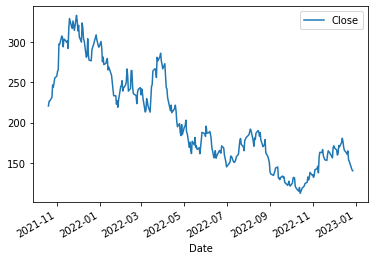

In [10]:
nvidia.iloc[-300:].plot.line(y='Close', use_index=True)

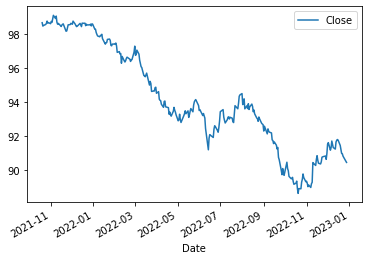

In [11]:
bitcoin.iloc[-300:].plot.line(y='Close', use_index=True)

### ETL

We clean data by eliminating useless columns (dividends and stock splits) and we create a new column `t1` which stores the closing price of the stock on the day after.

In [12]:
del nvidia['Dividends']
del nvidia['Stock Splits']

In [13]:
nvidia['t1'] = nvidia['Close'].shift(-1)

In [14]:
nvidia

,Open,High,Low,Close,Volume,t1
Date,,,,,,
1999-01-22 00:00:00-05:00,0.401517,0.448121,0.356107,0.376422,271468800,0.415856
1999-01-25 00:00:00-05:00,0.406296,0.420636,0.376422,0.415856,51048000,0.383592
1999-01-26 00:00:00-05:00,0.420636,0.429001,0.377616,0.383592,34320000,0.382397
1999-01-27 00:00:00-05:00,0.384787,0.394347,0.363276,0.382397,24436800,0.381202
1999-01-28 00:00:00-05:00,0.382397,0.384787,0.378811,0.381202,22752000,0.363277
...,...,...,...,...,...,...
2022-12-21 00:00:00-05:00,161.139999,166.270004,161.020004,165.009995,32502500,153.389999
2022-12-22 00:00:00-05:00,160.940002,161.380005,148.820007,153.389999,56504500,152.059998
2022-12-23 00:00:00-05:00,151.960007,153.389999,148.830002,152.059998,34910900,141.210007


### Target

We add the column `Target` which takes value 0 and 1. 

- When the closing price during time *t1* is higher than the closing price on *t*, the target value will be one: **buy**
- When the closing price during time *t1* is lower than the closing price in *t*, the target value will be zero: **sell**

In [15]:
nvidia['Target'] = (nvidia['t1'] > nvidia['Close']).astype(int)

In [16]:
nvidia

,Open,High,Low,Close,Volume,t1,Target
Date,,,,,,,
1999-01-22 00:00:00-05:00,0.401517,0.448121,0.356107,0.376422,271468800,0.415856,1
1999-01-25 00:00:00-05:00,0.406296,0.420636,0.376422,0.415856,51048000,0.383592,0
1999-01-26 00:00:00-05:00,0.420636,0.429001,0.377616,0.383592,34320000,0.382397,0
1999-01-27 00:00:00-05:00,0.384787,0.394347,0.363276,0.382397,24436800,0.381202,0
1999-01-28 00:00:00-05:00,0.382397,0.384787,0.378811,0.381202,22752000,0.363277,0
...,...,...,...,...,...,...,...
2022-12-21 00:00:00-05:00,161.139999,166.270004,161.020004,165.009995,32502500,153.389999,0
2022-12-22 00:00:00-05:00,160.940002,161.380005,148.820007,153.389999,56504500,152.059998,0
2022-12-23 00:00:00-05:00,151.960007,153.389999,148.830002,152.059998,34910900,141.210007,0


### Merge data

We create a unique dataframe containing data both from NVIDIA and bitcoin.

In [17]:
bitcoin.rename(columns = {'Close': 'Close_B', 'High': 'High_B', 'Low': 'Low_B', 
                       'Adj Close': 'Adj Close_B', 'Volume': 'Volume_B', 'Open': 'Open_B'}, 
            inplace = True)

In [18]:
bitcoin['t1_B'] = bitcoin['Close_B'].shift(-1)

In [19]:
bitcoin['Target_B'] = (bitcoin['t1_B'] > bitcoin['Close_B']).astype(int)

In [20]:
del bitcoin['Dividends']
del bitcoin['Stock Splits']

In [21]:
bitcoin

,Open_B,High_B,Low_B,Close_B,Volume_B,Capital Gains,t1_B,Target_B
Date,,,,,,,,
2020-10-01 00:00:00-04:00,100.000000,100.000000,100.000000,100.000000,0,0.0,100.000000,0
2020-10-02 00:00:00-04:00,100.000000,100.000000,100.000000,100.000000,0,0.0,99.995003,0
2020-10-05 00:00:00-04:00,100.029999,100.040001,99.995003,99.995003,10725,0.0,100.029999,1
2020-10-06 00:00:00-04:00,100.010002,100.029999,100.010002,100.029999,10080,0.0,99.919998,0
2020-10-07 00:00:00-04:00,99.949997,99.959999,99.919998,99.919998,6350,0.0,99.995003,1
...,...,...,...,...,...,...,...,...
2022-12-21 00:00:00-05:00,90.965698,90.965698,90.965698,90.965698,171,0.0,90.945198,0
2022-12-22 00:00:00-05:00,90.945198,90.945198,90.945198,90.945198,2,0.0,90.804497,0
2022-12-23 00:00:00-05:00,90.771004,90.804497,90.760002,90.804497,1308,0.0,90.509598,0


In [22]:
nvidia = nvidia.merge(bitcoin, how='inner', on='Date')

In [23]:
nvidia

,Open,High,Low,Close,Volume,t1,Target,Open_B,High_B,Low_B,Close_B,Volume_B,Capital Gains,t1_B,Target_B
Date,,,,,,,,,,,,,,,
2020-10-01 00:00:00-04:00,137.290961,137.338362,134.324702,135.858978,52500400,130.348114,0,100.000000,100.000000,100.000000,100.000000,0,0.0,100.000000,0
2020-10-02 00:00:00-04:00,131.972198,134.911019,130.235847,130.348114,55249600,136.138382,1,100.000000,100.000000,100.000000,100.000000,0,0.0,99.995003,0
2020-10-05 00:00:00-04:00,132.081920,136.155847,131.949691,136.138382,47982000,137.076431,1,100.029999,100.040001,99.995003,99.995003,10725,0.0,100.029999,1
2020-10-06 00:00:00-04:00,138.009465,141.122905,136.362922,137.076431,78442000,139.346649,1,100.010002,100.029999,100.010002,100.029999,10080,0.0,99.919998,0
2020-10-07 00:00:00-04:00,139.703396,140.895893,138.343756,139.346649,41808400,138.096771,0,99.949997,99.959999,99.919998,99.919998,6350,0.0,99.995003,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-21 00:00:00-05:00,161.139999,166.270004,161.020004,165.009995,32502500,153.389999,0,90.965698,90.965698,90.965698,90.965698,171,0.0,90.945198,0
2022-12-22 00:00:00-05:00,160.940002,161.380005,148.820007,153.389999,56504500,152.059998,0,90.945198,90.945198,90.945198,90.945198,2,0.0,90.804497,0
2022-12-23 00:00:00-05:00,151.960007,153.389999,148.830002,152.059998,34910900,141.210007,0,90.771004,90.804497,90.760002,90.804497,1308,0.0,90.509598,0


### Model

Now that we have merged data on a single dataframe, we are ready to run our **predictive model**.

In [24]:
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

In [25]:
nvidia = nvidia.dropna()

In [26]:
print(nvidia.columns)

Index(['Open', 'High', 'Low', 'Close', 'Volume', 't1', 'Target', 'Open_B',
       'High_B', 'Low_B', 'Close_B', 'Volume_B', 'Capital Gains', 't1_B',
       'Target_B'],
      dtype='object')


In [27]:
train = nvidia.iloc[:-50]
test = nvidia.iloc[-50:]

predictors = ['Open', 'High', 'Low', 'Close', 'Volume', 't1', 'Open_B',
       'High_B', 'Low_B', 'Close_B', 'Volume_B', 't1_B', 'Target_B']

model.fit(train[predictors], train['Target'])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [28]:
preds = model.predict(test[predictors])
preds = pd.Series(preds, index = test.index)

In [29]:
precision_score(test['Target'], preds)

1.0

## Model n°2 - Financia Indicators

We will use some technical indicators, implemented in Pandas through the `FinTA` library, to better predict the behavior of the NVIDIA stock.

In [ ]:
stock = 'NVDA'

nvidia = yf.Ticker(stock)
nvidia = nvidia.history(period='max')

nvidia

In [ ]:
nvidia['t1'] = nvidia['Close'].shift(-1)

In [ ]:
nvidia['Target'] = (nvidia['t1'] > nvidia['Close']).astype(int)

In [ ]:
del nvidia['Dividends']
del nvidia['Stock Splits']

In [ ]:
nvidia

,Open,High,Low,Close,Volume,t1,Target
Date,,,,,,,
1999-01-22 00:00:00-05:00,0.401517,0.448121,0.356107,0.376422,271468800.0,0.415857,1
1999-01-25 00:00:00-05:00,0.406296,0.420636,0.376422,0.415857,51048000.0,0.383592,0
1999-01-26 00:00:00-05:00,0.420636,0.429001,0.377616,0.383592,34320000.0,0.382397,0
1999-01-27 00:00:00-05:00,0.384787,0.394347,0.363277,0.382397,24436800.0,0.381202,0
1999-01-28 00:00:00-05:00,0.382397,0.384787,0.378811,0.381202,22752000.0,0.363277,0
...,...,...,...,...,...,...,...
2022-12-02 00:00:00-05:00,166.589996,169.330002,164.449997,168.759995,37119700.0,166.100006,0
2022-12-05 00:00:00-05:00,166.789993,169.949997,164.720001,166.100006,35225500.0,159.869995,0
2022-12-06 00:00:00-05:00,165.300003,165.729996,158.190002,159.869995,35269400.0,161.199997,1


### Smooth Data

To calculate indicators in a more accurate way, we need to remove noise by **smoothing** data with a simple function.
The purpose of this function is to ignore one-time *outliers* and take into account the effects of *seasonality* on the stock.

In [44]:
def smooth_data(data, alpha):
  return data.ewm(alpha=alpha).mean()

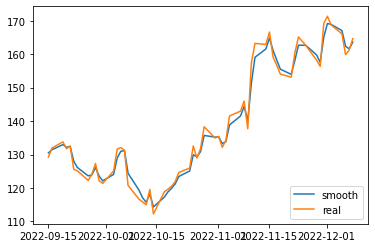

In [ ]:
alpha = 0.65
data = smooth_data(nvidia, alpha)

smooth_trend = data.iloc[-60:]['Close']
real_trend = nvidia.iloc[-60:]['Close']

plt.plot(smooth_trend)
plt.plot(real_trend)

plt.legend(["smooth", "real"], loc ="lower right")
plt.show()

### Financial Indicators

The FinTA library expects properly formatted DataFrames, with column names in lowercase: ["open", "high", "low", "close", "volume"]

In [ ]:
data.rename(columns = {'Close': 'close', 'High': 'high', 'Low': 'low', 
                       'Adj Close': 'adj close', 'Volume': 'volume', 'Open': 'open'}, 
            inplace = True)

We choose the following indicators:

- **OBV**: On Balance Volume
- **ADL**: Accumulation Distribution Line
- **ADX**: Average Directional Index
- **RSI**: Relative Strenght Index
- **STOCH**: Stochastic Oscillator
- **SMA**: Simple Moving Average

In [ ]:
indicators = ['OBV', 'ADL', 'ADX', 'RSI', 'STOCH', 'SMA']

In [ ]:
# indicators = ['RSI', 'STOCH', 'ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'OBV', 'CCI', 'EMV']

In [ ]:
# indicators = ['SMA', 'SMM', 'SSMA', 'EMA', 'DEMA', 'TEMA', 'TRIMA', 'TRIX', 'VAMA', 'ER', 'KAMA', 
#              'ZLEMA', 'WMA', 'HMA', 'EVWMA', 'VWAP', 'SMMA', 'MOM', 'ROC', 'RSI', 'IFT_RSI']

In [ ]:
for indicator in indicators:
  data[indicator] = eval('TA.' + indicator + '(data)')

In [ ]:
print(data.columns)

Index(['open', 'high', 'low', 'close', 'volume', 't1', 'Target', 'OBV', 'ADL',
       'ADX', 'RSI', 'STOCH', 'SMA'],
      dtype='object')


In [ ]:
print(nvidia.columns)

Index(['Open', 'High', 'Low', 'Close', 'Volume', 't1', 'Target'], dtype='object')


In [ ]:
to_del = ['open', 'high', 'low', 'close', 'volume', 't1', 'Target']

In [ ]:
for column in to_del:
  del data[column]

In [ ]:
nvidia = nvidia.merge(data, how='inner', on='Date')

In [ ]:
print(len(nvidia))

6012


In [ ]:
nvidia = nvidia.dropna()

In [ ]:
print(len(nvidia))

5969


In [ ]:
nvidia

,Open,High,Low,Close,Volume,t1,Target,OBV,ADL,ADX,RSI,STOCH,SMA
Date,,,,,,,,,,,,,
1999-03-22 00:00:00-05:00,0.409882,0.411077,0.389567,0.389567,3667200.0,0.365667,0,2.132452e+07,-2.407830e+08,39.377604,47.304309,22.624717,0.392218
1999-03-23 00:00:00-05:00,0.391956,0.391956,0.358497,0.365667,16396800.0,0.363277,0,8.768430e+06,-2.486523e+08,37.734846,39.629783,9.472836,0.392193
1999-03-24 00:00:00-05:00,0.363277,0.365667,0.348937,0.363277,6086400.0,0.368057,1,4.176385e+05,-2.480554e+08,37.328375,36.823550,15.969228,0.391263
1999-03-25 00:00:00-05:00,0.362082,0.382397,0.360887,0.368057,4032000.0,0.400322,1,5.961215e+06,-2.491327e+08,36.505427,37.040011,16.475307,0.390707
1999-03-26 00:00:00-05:00,0.372837,0.401517,0.372837,0.400322,8827200.0,0.412272,1,1.363915e+07,-2.445306e+08,34.157348,48.373097,46.583324,0.390798
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-01 00:00:00-05:00,169.990005,172.649994,166.350006,171.350006,47097700.0,168.759995,0,1.986902e+10,4.383381e+09,35.181409,69.806974,93.598374,139.659584
2022-12-02 00:00:00-05:00,166.589996,169.330002,164.449997,168.759995,37119700.0,166.100006,0,1.982842e+10,4.412721e+09,35.693665,69.385154,91.961796,140.584605
2022-12-05 00:00:00-05:00,166.789993,169.949997,164.720001,166.100006,35225500.0,159.869995,0,1.979131e+10,4.411889e+09,36.187863,66.476843,82.421359,141.460603


In [ ]:
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

In [ ]:
print(nvidia.columns)

Index(['Open', 'High', 'Low', 'Close', 'Volume', 't1', 'Target', 'OBV', 'ADL',
       'ADX', 'RSI', 'STOCH', 'SMA'],
      dtype='object')


In [ ]:
train = nvidia.iloc[:-50]
test = nvidia.iloc[-50:]

predictors = ['Open', 'High', 'Low', 'Close', 'Volume', 't1', 'OBV', 'ADL',
       'ADX', 'RSI', 'STOCH', 'SMA']

model.fit(train[predictors], train['Target'])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [ ]:
preds = model.predict(test[predictors])
preds = pd.Series(preds, index = test.index)

In [ ]:
precision_score(test['Target'], preds)

0.6857142857142857

In [ ]:
def predict(train, test, predictors, model):
  model.fit(train[predictors], train['Target'])
  preds = model.predict(test[predictors])
  preds = pd.Series(preds, index = test.index, name = 'Predictions')
  combined = pd.concat([test['Target'], preds], axis = 1)
  return combined

In [ ]:
def backtest(data, model, predictors, start=2500, step=250):
  all_predictions = []

  for i in range(start, data.shape[0], step):
    train = data.iloc[0:i].copy()
    test = data.iloc[i:(i + step)].copy()
    predictions = predict(train, test, predictors, model)
    all_predictions.append(predictions)
  return pd.concat(all_predictions)

In [ ]:
predictions = backtest(nvidia, model, predictors)

In [ ]:
predictions['Predictions'].value_counts()

0    2268
1    1234
Name: Predictions, dtype: int64

In [ ]:
precision_score(predictions['Target'], predictions['Predictions'])

0.6176948051948052

## Model n°3 - Linear Regression

We train a regression model using historic pricing data and technical indicators to make predictions on future prices. The goal is to find the right combination of features that maximizes the model accuracy.

In [31]:
#import pandas_ta as ta
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [88]:
stock = 'NVDA'

nvidia = yf.Ticker(stock)
nvidia = nvidia.history(period='max')

nvidia

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1999-01-22 00:00:00-05:00,0.401517,0.448121,0.356107,0.376422,271468800,0.0,0.0
1999-01-25 00:00:00-05:00,0.406296,0.420636,0.376422,0.415857,51048000,0.0,0.0
1999-01-26 00:00:00-05:00,0.420636,0.429002,0.377617,0.383592,34320000,0.0,0.0
1999-01-27 00:00:00-05:00,0.384787,0.394347,0.363277,0.382397,24436800,0.0,0.0
1999-01-28 00:00:00-05:00,0.382397,0.384787,0.378811,0.381202,22752000,0.0,0.0
...,...,...,...,...,...,...,...
2022-12-22 00:00:00-05:00,160.940002,161.380005,148.820007,153.389999,56504500,0.0,0.0
2022-12-23 00:00:00-05:00,151.960007,153.389999,148.830002,152.059998,34910900,0.0,0.0
2022-12-27 00:00:00-05:00,150.740005,151.000000,140.559998,141.210007,46490200,0.0,0.0


In [89]:
print(nvidia.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6025 entries, 1999-01-22 00:00:00-05:00 to 2022-12-29 00:00:00-05:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          6025 non-null   float64
 1   High          6025 non-null   float64
 2   Low           6025 non-null   float64
 3   Close         6025 non-null   float64
 4   Volume        6025 non-null   int64  
 5   Dividends     6025 non-null   float64
 6   Stock Splits  6025 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 505.6 KB
None


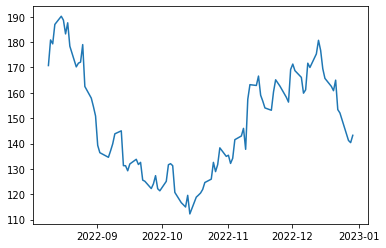

In [90]:
plt.plot(nvidia.iloc[-100:]['Close'])

We calculate the Exponential Moving Average (**EMA**) and we add it to the dataframe as a new column. The idea is to use this indicator to predict the nvidia stock prices.

In [92]:
nvidia['EMA'] = TA.EMA(nvidia)

In [93]:
to_del = ['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits']

for col in to_del:
  del nvidia[col]

In [94]:
nvidia

,Close,EMA
Date,,
1999-01-22 00:00:00-05:00,0.376422,0.376422
1999-01-25 00:00:00-05:00,0.415857,0.398330
1999-01-26 00:00:00-05:00,0.383592,0.392290
1999-01-27 00:00:00-05:00,0.382397,0.388939
1999-01-28 00:00:00-05:00,0.381202,0.386637
...,...,...
2022-12-22 00:00:00-05:00,153.389999,163.971122
2022-12-23 00:00:00-05:00,152.059998,161.588897
2022-12-27 00:00:00-05:00,141.210007,157.513119


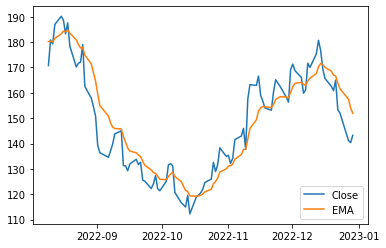

In [95]:
plt.plot(nvidia.iloc[-100:]['Close'])
plt.plot(nvidia.iloc[-100:]['EMA'])

plt.legend(["Close", "EMA"], loc ="lower right")
plt.show()

We divide the dataframe in train and test set following a 80/20 split using sklearn `train_test_split` method.

In [96]:
X_train, X_test, y_train, y_test = train_test_split(nvidia[['Close']], nvidia[['EMA']], test_size=.2)

In [97]:
print(X_test.describe())
print(X_train.describe())

             Close
count  1205.000000
mean     30.182255
std      59.345082
min       0.313088
25%       2.211783
50%       3.759725
75%      23.212061
max     329.501556
             Close
count  4820.000000
mean     28.119923
std      55.683092
min       0.313088
25%       2.469518
50%       3.890122
75%      24.755666
max     333.407410


In [98]:
model = LinearRegression()

In [99]:
model.fit(X_train, y_train)

LinearRegression()

In [100]:
y_pred = model.predict(X_test)

In [101]:
print('Model Coefficients: {}'.format(model.coef_))
print('Standard Deviation: {}'.format(np.std(y_pred)))
print('Mean Absolute Error: {}'.format(mean_absolute_error(y_test, y_pred)))
print('Coefficient of Determination: {}'.format(r2_score(y_test, y_pred)))

Model Coefficients: [[0.99508094]]
Standard Deviation: 59.028651757472986
Mean Absolute Error: 1.081741444924155
Coefficient of Determination: 0.9969281352667896
